# Using Regularized Regression to predict Inflation, given commodity prices and Money Supply

Dataset is a self-cleaned combination of the following
- FRED M2(M2SL) 2025
- FRED Inflation, consumer prices for the World (FPCPITOTLZGWLD) 2024
- IMF Primary Commodity Prices 2025

Dataset Documentation
- PMETA : Metals Price Index, 2016 = 100, includes (Base Metals): Aluminum, Copper, Iron Ore, Lead, Molybdenum, Nickel, Tin, Uranium and Zinc
- POILAPSP : Crude Oil (petroleum), Price index, 2016 = 100, simple average of three spot prices; Dated Brent, West Texas Intermediate, and the Dubai Fateh
- PNGAS : Natural Gas Price Index, 2016 = 100, includes American, European and Japanese Natural Gas
- PFOOD : Food Price Index, 2016 = 100, includes Bananas, Cereal, Citrus-fruit, Dairy Products, Legumes, Meat, Non-citrus fruit, Seafood, Sugar, Vegetables, and Vegetable Oils
- M2SL : Before May 2020, M2 consists of M1 plus (1) savings deposits (including money market deposit accounts); (2) small-denomination time deposits (time deposits in amounts of less than 100,000) less individual retirement account (IRA) and Keogh balances at depository institutions; and (3) balances in retail money market funds (MMFs) less IRA and Keogh balances at MMFs. Beginning May 2020, M2 consists of M1 plus (1) small-denomination time deposits (time deposits in amounts of less than 100,000) less IRA and Keogh balances at depository institutions; and (2) balances in retail MMFs less IRA and Keogh balances at MMFs. Seasonally adjusted M2 is constructed by summing savings deposits (before May 2020), small-denomination time deposits, and retail MMFs, each seasonally adjusted separately, and adding this result to seasonally adjusted M1.

Data Justification 
- Choice of commodites : Reflective of large proportion of commodoties/GDP while remaining interpretable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit

Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_csv("MacroData.csv")

In [3]:
df.drop('Date',axis=1,inplace=True)

In [4]:
df.insert(0, 'Date', pd.date_range(start='1992-01-01', periods=len(df), freq='MS'))

In [5]:
N = len(df)

Source = pd.DataFrame({
    'Variable Name': [
        'PMETA',
        'POILAPSP',
        'PNGAS',
        'PFOOD',
        'M2SL',
        'Inflation'
    ],
    'Description': [
        'Metals Price Index',
        'Crude Oil (petroleum), Price index',
        'Natural Gas Price Index',
        'Food Price Index',
        'Money Supply',
        'Inflation'
    ],
    'Source': [
        'IMF Primary Commodity Prices 2025',
        'IMF Primary Commodity Prices 2025',
        'IMF Primary Commodity Prices 2025',
        'IMF Primary Commodity Prices 2025',
        'FRED M2(M2SL) 2025)',
        'FRED Inflation,(FPCPITOTLZGWLD) 2024'
    ],  
})
Source.set_index('Variable Name')

,Description,Source
Variable Name,,
PMETA,Metals Price Index,IMF Primary Commodity Prices 2025
POILAPSP,"Crude Oil (petroleum), Price index",IMF Primary Commodity Prices 2025
PNGAS,Natural Gas Price Index,IMF Primary Commodity Prices 2025
PFOOD,Food Price Index,IMF Primary Commodity Prices 2025
M2SL,Money Supply,FRED M2(M2SL) 2025)
Inflation,Inflation,"FRED Inflation,(FPCPITOTLZGWLD) 2024"


In [6]:
df.head()

,Date,PMETA,POILAPSP,PNGAS,PFOOD,M2SL,Inflation,Cumulative Inflation
0,1992-01-01,46.95,39.56,54.06,57.73,3381.2,7.636109,96.487928
1,1992-02-01,44.41,40.33,62.27,56.27,3419.1,7.144587,103.632516
2,1992-03-01,40.15,33.02,61.89,60.81,3474.9,10.247936,113.880451
3,1992-04-01,62.26,36.98,54.37,60.15,3492.4,9.077381,122.957832
4,1992-05-01,53.67,39.20,74.92,65.59,3647.9,6.526096,129.483928


## 1.0 Reproducibility

In [7]:
np.random.seed(12)

## 2.0 Dataset metadata

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  33 non-null     datetime64[ns]
 1   PMETA                 33 non-null     float64       
 2   POILAPSP              33 non-null     float64       
 3   PNGAS                 33 non-null     float64       
 4   PFOOD                 33 non-null     float64       
 5   M2SL                  33 non-null     float64       
 6   Inflation             33 non-null     float64       
 7   Cumulative Inflation  33 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 2.1 KB


In [9]:
# Date's covered
print(min(df['Date']))
print(max(df['Date']))

1992-01-01 00:00:00
1994-09-01 00:00:00


## 3.0 Exploratory Data Analysis

### 3.1 Descriptive Statistics

In [10]:
summary1 = df.describe()
summary = summary1.T
summary

,count,mean,min,25%,50%,75%,max,std
Date,33,1993-05-01 18:54:32.727272704,1992-01-01 00:00:00,1992-09-01 00:00:00,1993-05-01 00:00:00,1994-01-01 00:00:00,1994-09-01 00:00:00,NaN
PMETA,33.0,110.193519,36.4,49.22,99.7,159.43,225.06,60.897353
POILAPSP,33.0,111.18316,26.22,53.09,107.77,158.36,223.25,63.768873
PNGAS,33.0,146.005401,49.62,75.12,144.35,184.56,389.05,77.201765
PFOOD,33.0,90.311475,56.27,64.62,89.05,108.67,141.83,27.185783
M2SL,33.0,9265.048485,3381.2,4667.6,7517.5,12505.5,21587.3,5591.390977
Inflation,33.0,4.395816,1.443857,2.860449,3.517999,5.55413,10.247936,2.332781
Cumulative Inflation,33.0,174.543687,96.487928,146.610811,182.033043,204.823119,233.913746,38.024177


In [11]:
N = len(df)

missing = df.isna().sum()
percent = (missing / N)*100

missing_summary = pd.DataFrame({
    'Missing': missing,
    'Percent Missing': percent})

missing_summary['Treatment'] = 'N/A'
missing_summary.loc['PMETA','Treatment'] = 'Kalman Smoothing'
missing_summary

,Missing,Percent Missing,Treatment
Date,0,0.0,N/A
PMETA,0,0.0,Kalman Smoothing
POILAPSP,0,0.0,N/A
PNGAS,0,0.0,N/A
PFOOD,0,0.0,N/A
M2SL,0,0.0,N/A
Inflation,0,0.0,N/A
Cumulative Inflation,0,0.0,N/A


### 3.2 Exploratory Visualisation 

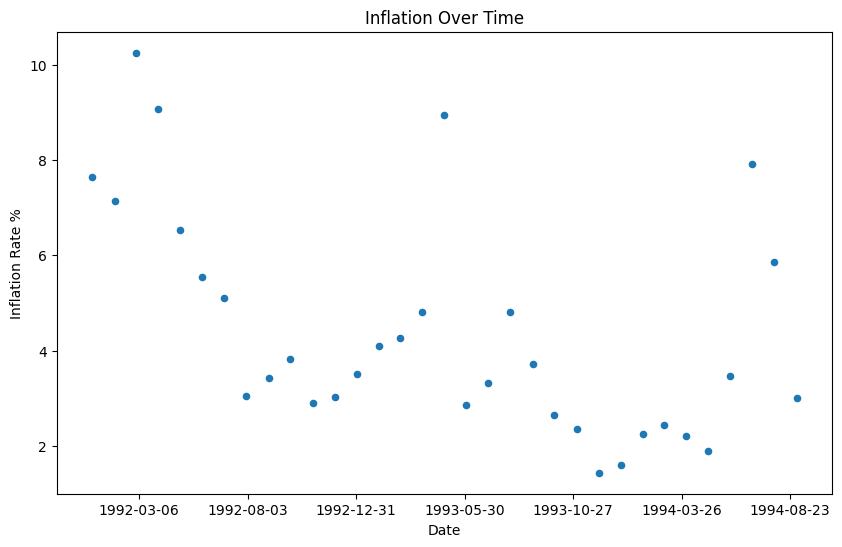

In [12]:
ax = df.plot.scatter(x='Date',
                     y='Inflation',
                     title='Inflation Over Time',
                     figsize=(10,6),
                     ylabel='Inflation Rate %'
                    )
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

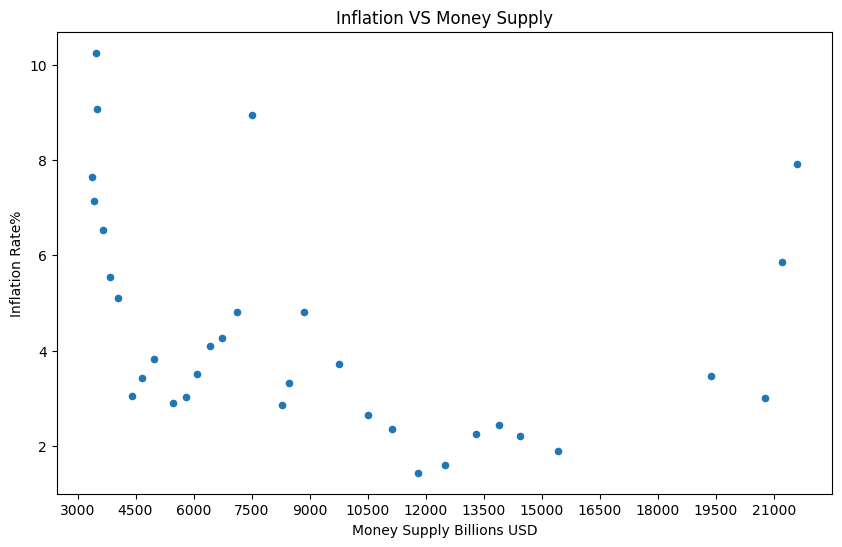

In [13]:
ax = df.plot.scatter(
    x='M2SL',
    y='Inflation',
    title='Inflation VS Money Supply',
    figsize=(10,6),
    xlabel='Money Supply Billions USD',
    ylabel='Inflation Rate%'
    )
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=16))

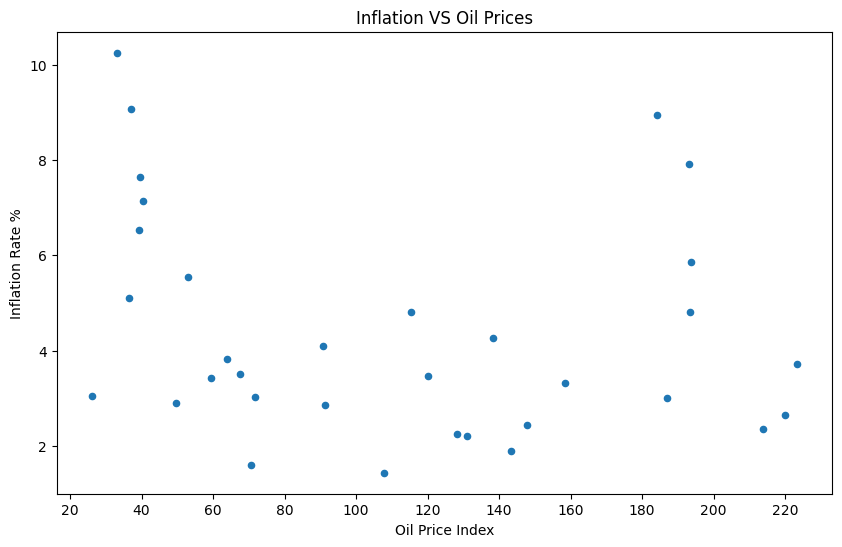

In [14]:
ax = df.plot.scatter(
    x='POILAPSP',
    y='Inflation',
    title='Inflation VS Oil Prices',
    figsize=(10,6),
    xlabel='Oil Price Index',
    ylabel='Inflation Rate %'
    )
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=14))

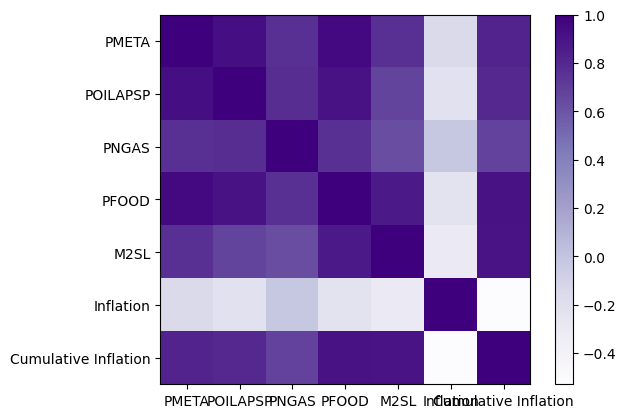

In [15]:
corr = df.drop(columns='Date').corr()

# Plot heatmap
plt.imshow(corr, cmap='Purples', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)
plt.show()

In [16]:
X = df[['PMETA','POILAPSP','PNGAS','PFOOD','M2SL']]
y = df['Inflation']

## 4.0 Feature Engineering

### 4.1 Stationarity

- Use of M-M inflation must be matched by growth rates to ensure model picks up relationships not trends

In [17]:
N = len(df)

Stationary = pd.DataFrame({
    'Variable Name': [
        'PMETA',
        'POILAPSP',
        'PNGAS',
        'PFOOD',
        'M2SL',
        'Inflation'
    ],
    'Stationary?': [
        'No',
        'No',
        'No',
        'No',
        'No',
        'Yes'
    ],
    'Transformation': [
        'Log-diff',
        'Log-dif5',
        'Log-diff',
        'Log-diff',
        'Log-diff)',
        'N/A'
    ],  
})
Stationary.set_index('Variable Name')

,Stationary?,Transformation
Variable Name,,
PMETA,No,Log-diff
POILAPSP,No,Log-dif5
PNGAS,No,Log-diff
PFOOD,No,Log-diff
M2SL,No,Log-diff)
Inflation,Yes,N/A


In [18]:
for col in df.columns[1:6]:
    df[col + '_trans'] = np.log(df[col]).diff()

In [19]:
df.head()

,Date,PMETA,POILAPSP,PNGAS,PFOOD,M2SL,Inflation,Cumulative Inflation,PMETA_trans,POILAPSP_trans,PNGAS_trans,PFOOD_trans,M2SL_trans
0,1992-01-01,46.95,39.56,54.06,57.73,3381.2,7.636109,96.487928,NaN,NaN,NaN,NaN,NaN
1,1992-02-01,44.41,40.33,62.27,56.27,3419.1,7.144587,103.632516,-0.055619,0.019277,0.141385,-0.025615,0.011147
2,1992-03-01,40.15,33.02,61.89,60.81,3474.9,10.247936,113.880451,-0.100842,-0.199982,-0.006121,0.077593,0.016188
3,1992-04-01,62.26,36.98,54.37,60.15,3492.4,9.077381,122.957832,0.438697,0.113264,-0.129546,-0.010913,0.005023
4,1992-05-01,53.67,39.20,74.92,65.59,3647.9,6.526096,129.483928,-0.148465,0.058300,0.320608,0.086582,0.043562


In [20]:
df.dropna()

,Date,PMETA,POILAPSP,PNGAS,PFOOD,M2SL,Inflation,Cumulative Inflation,PMETA_trans,POILAPSP_trans,PNGAS_trans,PFOOD_trans,M2SL_trans
1,1992-02-01,44.41000,40.330000,62.270000,56.270000,3419.1,7.144587,103.632516,-0.055619,0.019277,0.141385,-0.025615,0.011147
2,1992-03-01,40.15000,33.020000,61.890000,60.810000,3474.9,10.247936,113.880451,-0.100842,-0.199982,-0.006121,0.077593,0.016188
3,1992-04-01,62.26000,36.980000,54.370000,60.150000,3492.4,9.077381,122.957832,0.438697,0.113264,-0.129546,-0.010913,0.005023
4,1992-05-01,53.67000,39.200000,74.920000,65.590000,3647.9,6.526096,129.483928,-0.148465,0.058300,0.320608,0.086582,0.043562
5,1992-06-01,51.63000,53.090000,85.010000,64.370000,3834.6,5.554130,135.038058,-0.038751,0.303312,0.126348,-0.018776,0.049913
6,1992-07-01,43.94000,36.610000,62.110000,68.520000,4056.2,5.097291,140.135349,-0.161278,-0.371667,-0.313862,0.062478,0.056181
7,1992-08-01,36.40000,26.220000,49.620000,64.620000,4403.0,3.041947,143.177296,-0.188256,-0.333799,-0.224513,-0.058602,0.082040
8,1992-09-01,49.22000,59.520000,75.120000,58.490000,4667.6,3.433516,146.610811,0.301731,0.819790,0.414693,-0.099668,0.058359
9,1992-10-01,46.20000,63.980000,161.350000,58.580000,4978.3,3.836573,150.447384,-0.063320,0.072258,0.764489,0.001538,0.064443
10,1992-11-01,40.40000,49.540000,66.850000,59.190000,5460.9,2.907999,153.355383,-0.134150,-0.255790,-0.881125,0.010359,0.092525


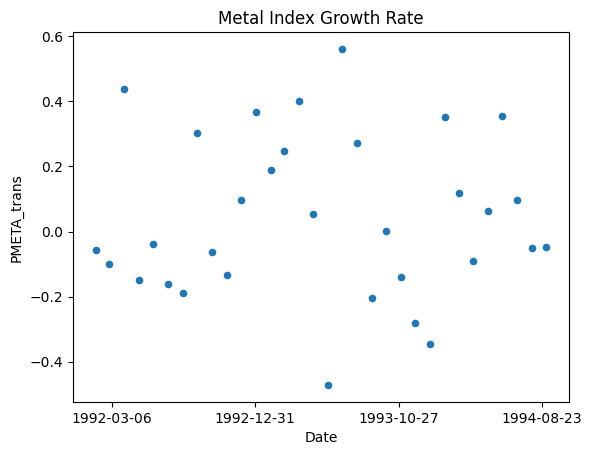

In [21]:
# Quick test for stationarity
ax = df.plot.scatter(x='Date',y='PMETA_trans',title='Metal Index Growth Rate')
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=4))

### 4.2 Lagging 

- Importantly, changes in money-supply or prices of today don't usually have immediate impacts on inflation. More likely, these changes influence the economy months later, hence the need to lag features.

In [22]:
# Since we've now created collumns with NA's that would prove problematic we need to remove NaN rows.
df.dropna(inplace=True)
df.head(15)

,Date,PMETA,POILAPSP,PNGAS,PFOOD,M2SL,Inflation,Cumulative Inflation,PMETA_trans,POILAPSP_trans,PNGAS_trans,PFOOD_trans,M2SL_trans
1,1992-02-01,44.41,40.33,62.27,56.27,3419.1,7.144587,103.632516,-0.055619,0.019277,0.141385,-0.025615,0.011147
2,1992-03-01,40.15,33.02,61.89,60.81,3474.9,10.247936,113.880451,-0.100842,-0.199982,-0.006121,0.077593,0.016188
3,1992-04-01,62.26,36.98,54.37,60.15,3492.4,9.077381,122.957832,0.438697,0.113264,-0.129546,-0.010913,0.005023
4,1992-05-01,53.67,39.20,74.92,65.59,3647.9,6.526096,129.483928,-0.148465,0.058300,0.320608,0.086582,0.043562
5,1992-06-01,51.63,53.09,85.01,64.37,3834.6,5.554130,135.038058,-0.038751,0.303312,0.126348,-0.018776,0.049913
6,1992-07-01,43.94,36.61,62.11,68.52,4056.2,5.097291,140.135349,-0.161278,-0.371667,-0.313862,0.062478,0.056181
7,1992-08-01,36.40,26.22,49.62,64.62,4403.0,3.041947,143.177296,-0.188256,-0.333799,-0.224513,-0.058602,0.082040
8,1992-09-01,49.22,59.52,75.12,58.49,4667.6,3.433516,146.610811,0.301731,0.819790,0.414693,-0.099668,0.058359
9,1992-10-01,46.20,63.98,161.35,58.58,4978.3,3.836573,150.447384,-0.063320,0.072258,0.764489,0.001538,0.064443
10,1992-11-01,40.40,49.54,66.85,59.19,5460.9,2.907999,153.355383,-0.134150,-0.255790,-0.881125,0.010359,0.092525


In [23]:
#df.drop(columns=['Cumulative Inflation'], inplace=True)

## 5.0 Time-Series Train-Test-Splitting

Crucially, time-series data introduces requirements to advance away from standard train-test splitting, to prevent data leakage. For this project expanding-window has been deemed as the most appropriate train-test-split methodology to ensure the model has the ability to learn from vast historic data while also respecting temporal impact of data.

In [24]:
y_diff = df['Inflation'].diff().dropna()
X_diff = df[[c for c in df.columns if c.endswith('_trans') or  c.endswith('_L1') or c.endswith('_L3') or c.endswith('_L5')]]  # replace with your chosen feature columns
X_diff = X_diff.loc[y_diff.index].dropna()
y_diff = y_diff.loc[X_diff.index]  # align

X_final = X_diff.copy()
y_final = y_diff.copy()
tscv = TimeSeriesSplit(n_splits=5, test_size=6)

In [25]:
X_final

,PMETA_trans,POILAPSP_trans,PNGAS_trans,PFOOD_trans,M2SL_trans
2,-0.100842,-0.199982,-0.006121,0.077593,0.016188
3,0.438697,0.113264,-0.129546,-0.010913,0.005023
4,-0.148465,0.058300,0.320608,0.086582,0.043562
5,-0.038751,0.303312,0.126348,-0.018776,0.049913
6,-0.161278,-0.371667,-0.313862,0.062478,0.056181
7,-0.188256,-0.333799,-0.224513,-0.058602,0.082040
8,0.301731,0.819790,0.414693,-0.099668,0.058359
9,-0.063320,0.072258,0.764489,0.001538,0.064443
10,-0.134150,-0.255790,-0.881125,0.010359,0.092525
11,0.097782,0.370965,0.567301,0.108599,0.062328


In [26]:
y_final

2     3.103348
3    -1.170555
4    -2.551285
5    -0.971966
6    -0.456838
7    -2.055345
8     0.391569
9     0.403057
10   -0.928574
11    0.117047
12    0.492954
13    0.589252
14    0.159924
15    0.543062
16    4.139716
17   -6.089505
18    0.465896
19    1.496052
20   -1.097070
21   -1.073653
22   -0.297183
23   -0.910633
24    0.161682
25    0.648737
26    0.188307
27   -0.236510
28   -0.300409
29    1.569740
30    4.446646
31   -2.051946
32   -2.855627
Name: Inflation, dtype: float64

## 6.0 Baselining: OLS

### 6.1 Fitting/Predicting 

In [27]:
import pandas as pd

# Initialize lists to store true values and predictions across all folds
all_y_test = []
all_y_pred = []
# Assuming tscv and X, y are defined as before:
tscv = TimeSeriesSplit(n_splits=6, test_size=3)


for fold, (train_index, test_index) in enumerate(tscv.split(X_final, y_final)):
    X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
    y_train, y_test = y_final.iloc[train_index], y_final.iloc[test_index]
    
    # 1. Train the model
    LinReg = LinearRegression() # Re-initialize for each fold
    LinReg.fit(X_train, y_train)
    
    # 2. Predict
    y_pred_linear = LinReg.predict(X_test)
    
    # 3. Store the results (appending the true values and the predictions)
    all_y_test.append(y_test)
    all_y_pred.append(pd.Series(y_pred_linear, index=y_test.index)) # Ensure index is included for clarity

# 4. Concatenate the lists of Series/DataFrames into final results
final_y_test = pd.concat(all_y_test)
final_y_pred = pd.concat(all_y_pred)

print(f"Total rows predicted across all folds: {len(final_y_pred)}")
# This count should be 5 folds * 3 test rows/fold = 15 total predictions (or slightly less/more depending on your initial data size and n_splits).
#Gemini (2025). Time Series Cross-Validation Implementation. Accessed [October 30, 2025].

Total rows predicted across all folds: 18


In [28]:
linear_baseline_df = pd.DataFrame({
    'True Inflation': final_y_test,
    'Predicted Inflation': final_y_pred
})

linear_baseline_df

,True Inflation,Predicted Inflation
15,0.543062,0.217718
16,4.139716,0.831983
17,-6.089505,-2.332740
18,0.465896,2.422985
19,1.496052,3.209903
20,-1.097070,-1.864214
21,-1.073653,-0.587363
22,-0.297183,-1.181731
23,-0.910633,-3.503270
24,0.161682,-2.197026


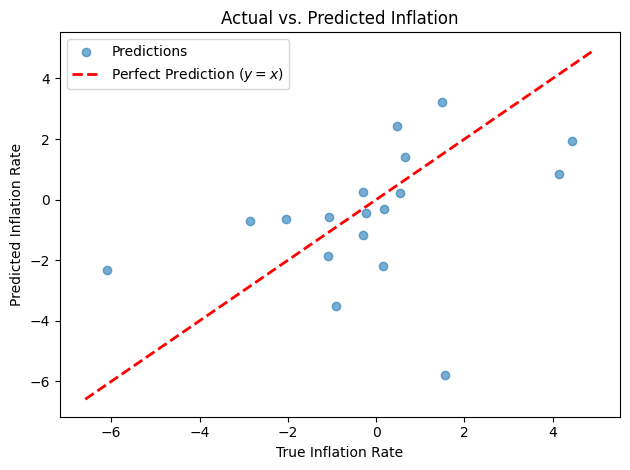

In [29]:
plt.scatter(
    linear_baseline_df['True Inflation'], 
    linear_baseline_df['Predicted Inflation'], 
    alpha=0.6,
    label='Predictions'
)

min_val = min(linear_baseline_df['True Inflation'].min(), linear_baseline_df['Predicted Inflation'].min())
max_val = max(linear_baseline_df['True Inflation'].max(), linear_baseline_df['Predicted Inflation'].max())
line_range = np.linspace(min_val - 0.5, max_val + 0.5, 100)

# Y=X
plt.plot(
    line_range, 
    line_range, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label='Perfect Prediction ($y=x$)'
)

plt.title('Actual vs. Predicted Inflation')
plt.xlabel('True Inflation Rate')
plt.ylabel('Predicted Inflation Rate')
plt.legend()
plt.tight_layout()
plt.show()

### 6.2 Evaluation 

In [30]:
def calculate_mape(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).
    y_true: Series or array of actual values.
    y_pred: Series or array of predicted values.
    """
    # Calculate the absolute percentage error: |(Actual - Predicted) / Actual|
    percentage_error = np.abs((y_true - y_pred) / y_true)
    
    # Calculate the mean and multiply by 100 to get a percentage
    mape = np.mean(percentage_error) * 100
    
    return mape

# --- Usage Example ---
# Assuming final_y_test and final_y_pred are available
# mape_result = calculate_mape(final_y_test, final_y_pred)
# print(f"MAPE: {mape_result:.2f}%")
def calculate_directional_accuracy(y_true, y_pred):
    """
    Calculates the Directional Accuracy (DA).
    DA measures the percentage of times the model correctly predicts 
    the direction of change (increase or decrease) from the previous period.
    """
    # 1. Ensure y_true is a Series so we can use .shift()
    y_true = pd.Series(y_true)
    
    # 2. Get the actual value from the previous time step (Actual_t-1)
    y_true_prev = y_true.shift(1)
    
    # 3. Calculate the sign of the ACTUAL change (Actual_t - Actual_t-1)
    actual_change_sign = np.sign(y_true - y_true_prev)
    
    # 4. Calculate the sign of the PREDICTED change (Predicted_t - Actual_t-1)
    # The 'change' is predicted relative to the *last known* true value.
    predicted_change_sign = np.sign(y_pred - y_true_prev)
    
    # 5. Check where the signs match (True = 1, False = 0)
    correct_direction = (actual_change_sign == predicted_change_sign)
    
    # Exclude the first data point (where shift is NaN) and calculate the mean
    da = np.mean(correct_direction[1:]) * 100
    
    return da

# --- Usage Example ---
# Assuming final_y_test and final_y_pred are available
# da_result = calculate_directional_accuracy(final_y_test, final_y_pred)
# print(f"Directional Accuracy: {da_result:.2f}%")
#Gemini (2025). Time Series Cross-Validation Implementation. Accessed [October 30, 2025].

In [31]:
rmse = np.sqrt(mean_squared_error(final_y_test, final_y_pred))
r2 = r2_score(final_y_test, final_y_pred)
mae = np.mean(np.abs(final_y_test - final_y_pred))
mape = calculate_mape(final_y_test, final_y_pred)
da = calculate_directional_accuracy(final_y_test, final_y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Directional Accuracy (DA): {da:.2f}%")

Root Mean Squared Error (RMSE): 2.5153
Mean Absolute Error (MAE): 1.8662
R-squared (R²): -0.1939
Mean Absolute Percentage Error (MAPE): 234.26%
Directional Accuracy (DA): 70.59%


## 7.0 Regularized Regression

### 7.1 Ridge Regression

#### 7.1.1 Hyperparameter Fitting

In [32]:
# Define parameters
alphas_to_test = [0.01, 0.1, 1, 10, 100, 1000,10000] 
alpha_results = {} 
tscv = TimeSeriesSplit(n_splits=6, test_size=3)

# loop over different values of alpha
for alpha in alphas_to_test:
    all_y_test = []
    all_y_pred = []
    
    # Perform expanding train,test splitting
    for train_index, test_index in tscv.split(X_final, y_final):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train, Predict, and Store result of alpha
        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        all_y_test.append(y_test)
        all_y_pred.append(pd.Series(y_pred, index=y_test.index))
    
    # Calculate RMSE for this alpha
    final_y_test_temp = pd.concat(all_y_test)
    final_y_pred_temp = pd.concat(all_y_pred)
    rmse = np.sqrt(mean_squared_error(final_y_test_temp, final_y_pred_temp))
    
    alpha_results[alpha] = rmse

# Determine the best alpha
best_alpha = min(alpha_results, key=alpha_results.get)

print(f"Alpha Tuning Complete. All Results:\n{alpha_results}")
print(f"\n--- Best Alpha Found: {best_alpha} (RMSE: {alpha_results[best_alpha]:.4f}) ---")

Alpha Tuning Complete. All Results:
{0.01: np.float64(4.934461320827047), 0.1: np.float64(4.9344099398283), 1: np.float64(4.9338984825031496), 10: np.float64(4.929005345704247), 100: np.float64(4.894262276674633), 1000: np.float64(4.812137826375039), 10000: np.float64(4.451285388819763)}

--- Best Alpha Found: 10000 (RMSE: 4.4513) ---


#### 7.1.2 Predicting 

In [33]:

# Initialize lists to store true values and predictions across all folds
all_y_test_ridge = []
all_y_pred_ridge = []
tscv = TimeSeriesSplit(n_splits=5, test_size=4)

for fold, (train_index, test_index) in enumerate(tscv.split(X_final, y_final)):
    X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
    y_train, y_test = y_final.iloc[train_index], y_final.iloc[test_index]
    
    # 1. Train the model
    RidgeReg = Ridge(alpha=10000) # Re-initialize for each fold
    RidgeReg.fit(X_train, y_train)
    
    # 2. Predict
    y_pred_ridge = RidgeReg.predict(X_test)
    
    # 3. Store the results (appending the true values and the predictions)
    all_y_test_ridge.append(y_test)
    all_y_pred_ridge.append(pd.Series(y_pred_ridge, index=y_test.index)) # Ensure index is included for clarity

# 4. Concatenate the lists of Series/DataFrames into final results
final_y_test_ridge = pd.concat(all_y_test_ridge)
final_y_pred_ridge = pd.concat(all_y_pred_ridge)

print(f"Total rows predicted across all folds: {len(final_y_pred_ridge)}")
# This count should be 5 folds * 3 test rows/fold = 15 total predictions (or slightly less/more depending on your initial data size and n_splits).

Total rows predicted across all folds: 20


#### 7.1.3 Evaluation

In [34]:
rmse_ridge = np.sqrt(mean_squared_error(final_y_test_ridge, final_y_pred_ridge))
r2_ridge = r2_score(final_y_test_ridge, final_y_pred_ridge)
mae_ridge = np.mean(np.abs(final_y_test_ridge - final_y_pred_ridge))
mape_ridge = calculate_mape(final_y_test_ridge, final_y_pred_ridge)
da_ridge = calculate_directional_accuracy(final_y_test_ridge, final_y_pred_ridge)

print(f"Root Mean Squared Error (RMSE): {rmse_ridge:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ridge:.4f}")
print(f"R-squared (R²): {r2_ridge:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ridge:.2f}%")
print(f"Directional Accuracy (DA): {da_ridge:.2f}%")

Root Mean Squared Error (RMSE): 2.2526
Mean Absolute Error (MAE): 1.5143
R-squared (R²): -0.0590
Mean Absolute Percentage Error (MAPE): 115.56%
Directional Accuracy (DA): 63.16%


In [35]:
print(f"Root Mean Squared Error (RMSE) Difference: {rmse_ridge-rmse:.4f}")
print(f"Mean Absolute Error (MAE Difference: {mae_ridge-mae:.4f}")
print(f"R-squared (R²) Difference: {r2_ridge-r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) Difference: {mape_ridge-mape:.2f}%")
print(f"Directional Accuracy (DA Difference): {da_ridge-da:.2f}%")

Root Mean Squared Error (RMSE) Difference: -2.1987
Mean Absolute Error (MAE Difference: -0.3519
R-squared (R²) Difference: 0.1349
Mean Absolute Percentage Error (MAPE) Difference: -118.69%
Directional Accuracy (DA Difference): -7.43%


Small improvements in R2 and Directional Accuracy. 

### 7.2 LASSO Regression

#### 7.2.1 Hyperparameter Fitting

In [ ]:
# converted to mark down as is corrected 

In [45]:
from sklearn.linear_model import Lasso  
alphas_to_test = [0.01, 0.1, 1, 10, 100, 1000, 10000] 
alpha_results_lasso = {} 
tscv = TimeSeriesSplit(n_splits=5, test_size=4)


for alpha in alphas_to_test:
    all_y_test_lasso = []
    all_y_pred_lasso = []
    
    
    for train_index, test_index in tscv.split(X_final, y_final):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        
        lasso = Lasso(alpha=alpha, max_iter=5000).fit(X_train, y_train)
        y_pred_lasso = lasso.predict(X_test)
        
        all_y_test_lasso.append(y_test)
        all_y_pred_lasso.append(pd.Series(y_pred, index=y_test.index))
    

    final_y_test_lasso = pd.concat(all_y_test_lasso)
    final_y_pred_lasso = pd.concat(all_y_pred_lasso)
    rmse = np.sqrt(mean_squared_error(final_y_test_lasso, final_y_pred_lasso))
    
    alpha_results_lasso[alpha] = rmse # <-- Use the new dictionary
    print(f"Lasso Alpha={alpha}: RMSE={rmse:.4f}")


best_alpha_lasso = min(alpha_results_lasso, key=alpha_results_lasso.get)

print(f"\nLasso Tuning Complete. All Results:\n{alpha_results_lasso}")
print(f"\n--- Best Lasso Alpha Found: {best_alpha_lasso} (RMSE: {alpha_results_lasso[best_alpha_lasso]:.4f}) ---")

<class 'ValueError'>: Length of values (3) does not match length of index (4)

#### 7.2.2 Predicting

In [37]:
# Initialize lists to store true values and predictions across all folds
all_y_test_lasso = []
all_y_pred_lasso = []
tscv = TimeSeriesSplit(n_splits=5, test_size=4)

for fold, (train_index, test_index) in enumerate(tscv.split(X_final, y_final)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 1. Train the model
    LassoReg = Lasso(alpha=0.01) # Re-initialize for each fold
    LassoReg.fit(X_train, y_train)
    
    # 2. Predict
    y_pred_lasso = LassoReg.predict(X_test)
    
    # 3. Store the results (appending the true values and the predictions)
    all_y_test_lasso.append(y_test)
    all_y_pred_lasso.append(pd.Series(y_pred_lasso, index=y_test.index)) # Ensure index is included for clarity

# 4. Concatenate the lists of Series/DataFrames into final results
final_y_test_lasso = pd.concat(all_y_test_lasso)
final_y_pred_lasso = pd.concat(all_y_pred_lasso)


#### 7.2.3 Evaluating Lasso model

In [38]:
rmse_lasso = np.sqrt(mean_squared_error(final_y_test_lasso, final_y_pred_lasso))
r2_lasso = r2_score(final_y_test_lasso, final_y_pred_lasso)
mae_lasso = np.mean(np.abs(final_y_test_lasso - final_y_pred_lasso))
mape_lasso = calculate_mape(final_y_test_lasso, final_y_pred_lasso)
da_lasso = calculate_directional_accuracy(final_y_test_lasso, final_y_pred_lasso)

print(f"Root Mean Squared Error (RMSE): {rmse_lasso:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lasso:.4f}")
print(f"R-squared (R²): {r2_lasso:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lasso:.2f}%")
print(f"Directional Accuracy (DA): {da_lasso:.2f}%")

Root Mean Squared Error (RMSE): 6.3821
Mean Absolute Error (MAE): 5.0704
R-squared (R²): -10.4751
Mean Absolute Percentage Error (MAPE): 180.25%
Directional Accuracy (DA): 57.89%


In [39]:
print(f"Root Mean Squared Error (RMSE) Difference: {rmse_lasso-rmse:.4f}")
print(f"Mean Absolute Error (MAE Difference: {mae_lasso-mae:.4f}")
print(f"R-squared (R²) Difference: {r2_lasso-r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) Difference: {mape_lasso-mape:.2f}%")
print(f"Directional Accuracy (DA Difference): {da_lasso-da:.2f}%")

Root Mean Squared Error (RMSE) Difference: 1.9308
Mean Absolute Error (MAE Difference: 3.2043
R-squared (R²) Difference: -10.2813
Mean Absolute Percentage Error (MAPE) Difference: -54.01%
Directional Accuracy (DA Difference): -12.69%


## 8.0 Polynomial Features

/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e-02, tolerance: 8.225e-03
  model = cd_fast.enet_coordinate_descent(



--- Model Comparison ---


,Model,Best Alpha,Poly Degree,RMSE,MAE,R²,MAPE (%),DA (%)
2,Ridge (poly degree 3),100,3,1.957502,1.367222,0.276915,138.861539,76.470588
1,Ridge (no poly),10,-,2.127197,1.598845,0.146113,191.330518,82.352941
3,Lasso (poly degree 3),1,3,2.158252,1.352234,0.120999,100.026388,64.705882
0,Lasso (no poly),0.1,-,2.186279,1.734186,0.098022,221.808270,76.470588
4,OLS (no poly),-,-,2.515284,1.866163,-0.193875,234.255224,82.352941
5,OLS (poly degree 3),-,3,3.519311,2.818801,-1.337224,343.706803,76.470588


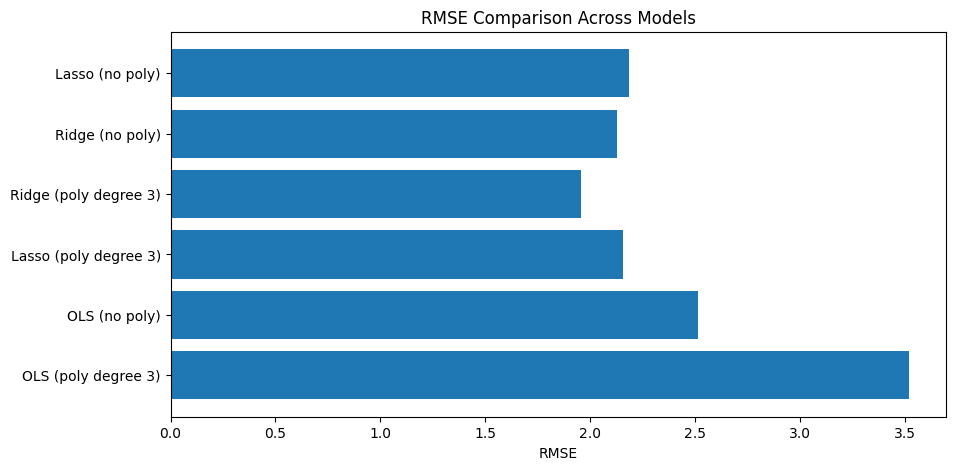

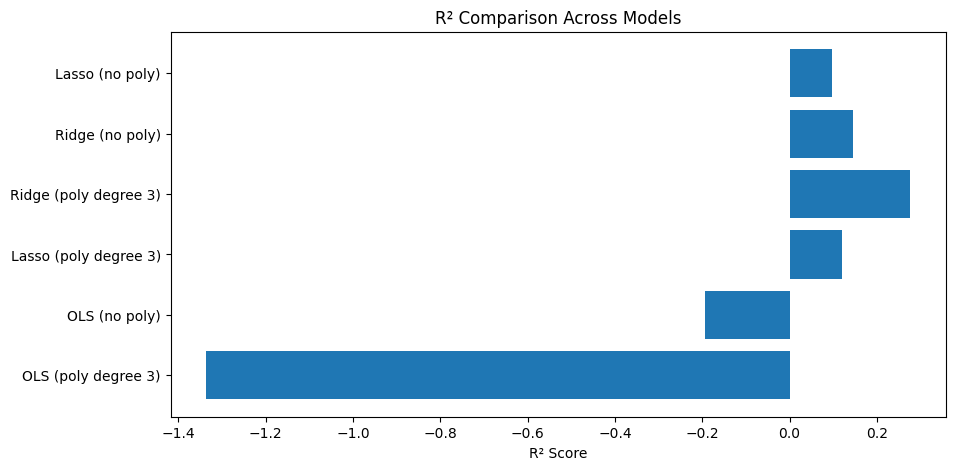

In [40]:
# ================================================
# POLY vs NON-POLY LASSO / RIDGE / OLS COMPARISON
# ================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Helper metrics ---
def safe_mape(y_true, y_pred, eps=1e-8):
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def calculate_directional_accuracy(y_true, y_pred):
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    return np.mean(direction_true == direction_pred) * 100

# ================================================
# 1️⃣ DATA PREPARATION
# ================================================

tscv = TimeSeriesSplit(n_splits=6, test_size=3)
results_summary = []

# ================================================
# 2️⃣ LASSO (NO POLY)
# ================================================
pipe_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])
param_grid_lasso = {'lasso__alpha': [0.01, 0.1, 1, 10, 100, 1000]}
gscv_lasso = GridSearchCV(pipe_lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=tscv)
gscv_lasso.fit(X_final, y_final)
best_alpha_lasso = gscv_lasso.best_params_['lasso__alpha']

final_y_test_lasso, final_y_pred_lasso = [], []
for train_idx, test_idx in tscv.split(X_final, y_final):
    X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
    y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]

    pipe_best_lasso = Pipeline([
        ('scale', StandardScaler()),
        ('lasso', Lasso(alpha=best_alpha_lasso, max_iter=10000))
    ])
    pipe_best_lasso.fit(X_train, y_train)
    y_pred = pipe_best_lasso.predict(X_test)

    final_y_test_lasso.append(y_test)
    final_y_pred_lasso.append(pd.Series(y_pred, index=y_test.index))

final_y_test_lasso = pd.concat(final_y_test_lasso)
final_y_pred_lasso = pd.concat(final_y_pred_lasso)

rmse_lasso = np.sqrt(mean_squared_error(final_y_test_lasso, final_y_pred_lasso))
r2_lasso = r2_score(final_y_test_lasso, final_y_pred_lasso)
mae_lasso = np.mean(np.abs(final_y_test_lasso - final_y_pred_lasso))
mape_lasso = safe_mape(final_y_test_lasso, final_y_pred_lasso)
da_lasso = calculate_directional_accuracy(final_y_test_lasso.values, final_y_pred_lasso.values)
results_summary.append(["Lasso (no poly)", best_alpha_lasso, "-", rmse_lasso, mae_lasso, r2_lasso, mape_lasso, da_lasso])

# ================================================
# 3️⃣ RIDGE (NO POLY)
# ================================================
pipe_ridge = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', Ridge())
])
param_grid_ridge = {'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000]}
gscv_ridge = GridSearchCV(pipe_ridge, param_grid_ridge, scoring='neg_mean_squared_error', cv=tscv)
gscv_ridge.fit(X_final, y_final)
best_alpha_ridge = gscv_ridge.best_params_['ridge__alpha']

final_y_test_ridge, final_y_pred_ridge = [], []
for train_idx, test_idx in tscv.split(X_final, y_final):
    X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
    y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]

    pipe_best_ridge = Pipeline([
        ('scale', StandardScaler()),
        ('ridge', Ridge(alpha=best_alpha_ridge))
    ])
    pipe_best_ridge.fit(X_train, y_train)
    y_pred = pipe_best_ridge.predict(X_test)

    final_y_test_ridge.append(y_test)
    final_y_pred_ridge.append(pd.Series(y_pred, index=y_test.index))

final_y_test_ridge = pd.concat(final_y_test_ridge)
final_y_pred_ridge = pd.concat(final_y_pred_ridge)

rmse_ridge = np.sqrt(mean_squared_error(final_y_test_ridge, final_y_pred_ridge))
r2_ridge = r2_score(final_y_test_ridge, final_y_pred_ridge)
mae_ridge = np.mean(np.abs(final_y_test_ridge - final_y_pred_ridge))
mape_ridge = safe_mape(final_y_test_ridge, final_y_pred_ridge)
da_ridge = calculate_directional_accuracy(final_y_test_ridge.values, final_y_pred_ridge.values)
results_summary.append(["Ridge (no poly)", best_alpha_ridge, "-", rmse_ridge, mae_ridge, r2_ridge, mape_ridge, da_ridge])

# ================================================
# 4️⃣ RIDGE (WITH POLY)
# ================================================
pipe_poly_ridge = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scale', StandardScaler()),
    ('ridge', Ridge())
])
param_grid_poly_ridge = {
    'poly__degree': [2, 3],
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000]
}
gscv_poly_ridge = GridSearchCV(pipe_poly_ridge, param_grid_poly_ridge, scoring='neg_mean_squared_error', cv=tscv)
gscv_poly_ridge.fit(X_final, y_final)
best_degree_poly_ridge = gscv_poly_ridge.best_params_['poly__degree']
best_alpha_poly_ridge = gscv_poly_ridge.best_params_['ridge__alpha']

final_y_test_poly_ridge, final_y_pred_poly_ridge = [], []
for train_idx, test_idx in tscv.split(X_final, y_final):
    X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
    y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]

    pipe_best_poly_ridge = Pipeline([
        ('poly', PolynomialFeatures(degree=best_degree_poly_ridge, include_bias=False)),
        ('scale', StandardScaler()),
        ('ridge', Ridge(alpha=best_alpha_poly_ridge))
    ])
    pipe_best_poly_ridge.fit(X_train, y_train)
    y_pred = pipe_best_poly_ridge.predict(X_test)

    final_y_test_poly_ridge.append(y_test)
    final_y_pred_poly_ridge.append(pd.Series(y_pred, index=y_test.index))

final_y_test_poly_ridge = pd.concat(final_y_test_poly_ridge)
final_y_pred_poly_ridge = pd.concat(final_y_pred_poly_ridge)

rmse_poly_ridge = np.sqrt(mean_squared_error(final_y_test_poly_ridge, final_y_pred_poly_ridge))
r2_poly_ridge = r2_score(final_y_test_poly_ridge, final_y_pred_poly_ridge)
mae_poly_ridge = np.mean(np.abs(final_y_test_poly_ridge - final_y_pred_poly_ridge))
mape_poly_ridge = safe_mape(final_y_test_poly_ridge, final_y_pred_poly_ridge)
da_poly_ridge = calculate_directional_accuracy(final_y_test_poly_ridge.values, final_y_pred_poly_ridge.values)
results_summary.append([f"Ridge (poly degree {best_degree_poly_ridge})", best_alpha_poly_ridge, best_degree_poly_ridge,
                        rmse_poly_ridge, mae_poly_ridge, r2_poly_ridge, mape_poly_ridge, da_poly_ridge])

# ================================================
# 5️⃣ LASSO (WITH POLY)
# ================================================
pipe_poly_lasso = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scale', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])
param_grid_poly_lasso = {
    'poly__degree': [2, 3],
    'lasso__alpha': [0.01, 0.1, 1, 10, 100, 1000]
}
gscv_poly_lasso = GridSearchCV(pipe_poly_lasso, param_grid_poly_lasso, scoring='neg_mean_squared_error', cv=tscv)
gscv_poly_lasso.fit(X_final, y_final)
best_degree_poly_lasso = gscv_poly_lasso.best_params_['poly__degree']
best_alpha_poly_lasso = gscv_poly_lasso.best_params_['lasso__alpha']

final_y_test_poly_lasso, final_y_pred_poly_lasso = [], []
for train_idx, test_idx in tscv.split(X_final, y_final):
    X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
    y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]

    pipe_best_poly_lasso = Pipeline([
        ('poly', PolynomialFeatures(degree=best_degree_poly_lasso, include_bias=False)),
        ('scale', StandardScaler()),
        ('lasso', Lasso(alpha=best_alpha_poly_lasso, max_iter=10000))
    ])
    pipe_best_poly_lasso.fit(X_train, y_train)
    y_pred = pipe_best_poly_lasso.predict(X_test)

    final_y_test_poly_lasso.append(y_test)
    final_y_pred_poly_lasso.append(pd.Series(y_pred, index=y_test.index))

final_y_test_poly_lasso = pd.concat(final_y_test_poly_lasso)
final_y_pred_poly_lasso = pd.concat(final_y_pred_poly_lasso)

rmse_poly_lasso = np.sqrt(mean_squared_error(final_y_test_poly_lasso, final_y_pred_poly_lasso))
r2_poly_lasso = r2_score(final_y_test_poly_lasso, final_y_pred_poly_lasso)
mae_poly_lasso = np.mean(np.abs(final_y_test_poly_lasso - final_y_pred_poly_lasso))
mape_poly_lasso = safe_mape(final_y_test_poly_lasso, final_y_pred_poly_lasso)
da_poly_lasso = calculate_directional_accuracy(final_y_test_poly_lasso.values, final_y_pred_poly_lasso.values)
results_summary.append([f"Lasso (poly degree {best_degree_poly_lasso})", best_alpha_poly_lasso, best_degree_poly_lasso,
                        rmse_poly_lasso, mae_poly_lasso, r2_poly_lasso, mape_poly_lasso, da_poly_lasso])

# ================================================
# 5️⃣.5️⃣ OLS (NO POLY) & (WITH POLY)
# ================================================
# --- OLS (NO POLY)
final_y_test_ols, final_y_pred_ols = [], []
for train_idx, test_idx in tscv.split(X_final, y_final):
    X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
    y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]

    model_ols = Pipeline([
        ('scale', StandardScaler()),
        ('ols', LinearRegression())
    ])
    model_ols.fit(X_train, y_train)
    y_pred = model_ols.predict(X_test)

    final_y_test_ols.append(y_test)
    final_y_pred_ols.append(pd.Series(y_pred, index=y_test.index))

final_y_test_ols = pd.concat(final_y_test_ols)
final_y_pred_ols = pd.concat(final_y_pred_ols)

rmse_ols = np.sqrt(mean_squared_error(final_y_test_ols, final_y_pred_ols))
r2_ols = r2_score(final_y_test_ols, final_y_pred_ols)
mae_ols = np.mean(np.abs(final_y_test_ols - final_y_pred_ols))
mape_ols = safe_mape(final_y_test_ols, final_y_pred_ols)
da_ols = calculate_directional_accuracy(final_y_test_ols.values, final_y_pred_ols.values)
results_summary.append(["OLS (no poly)", "-", "-", rmse_ols, mae_ols, r2_ols, mape_ols, da_ols])

# --- OLS (WITH POLY)
pipe_poly_ols = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scale', StandardScaler()),
    ('ols', LinearRegression())
])
param_grid_poly_ols = {'poly__degree': [2, 3]}
gscv_poly_ols = GridSearchCV(pipe_poly_ols, param_grid_poly_ols, scoring='neg_mean_squared_error', cv=tscv)
gscv_poly_ols.fit(X_final, y_final)
best_degree_poly_ols = gscv_poly_ols.best_params_['poly__degree']

final_y_test_poly_ols, final_y_pred_poly_ols = [], []
for train_idx, test_idx in tscv.split(X_final, y_final):
    X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
    y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]

    model_poly_ols = Pipeline([
        ('poly', PolynomialFeatures(degree=best_degree_poly_ols, include_bias=False)),
        ('scale', StandardScaler()),
        ('ols', LinearRegression())
    ])
    model_poly_ols.fit(X_train, y_train)
    y_pred = model_poly_ols.predict(X_test)

    final_y_test_poly_ols.append(y_test)
    final_y_pred_poly_ols.append(pd.Series(y_pred, index=y_test.index))

final_y_test_poly_ols = pd.concat(final_y_test_poly_ols)
final_y_pred_poly_ols = pd.concat(final_y_pred_poly_ols)

rmse_poly_ols = np.sqrt(mean_squared_error(final_y_test_poly_ols, final_y_pred_poly_ols))
r2_poly_ols = r2_score(final_y_test_poly_ols, final_y_pred_poly_ols)
mae_poly_ols = np.mean(np.abs(final_y_test_poly_ols - final_y_pred_poly_ols))
mape_poly_ols = safe_mape(final_y_test_poly_ols, final_y_pred_poly_ols)
da_poly_ols = calculate_directional_accuracy(final_y_test_poly_ols.values, final_y_pred_poly_ols.values)
results_summary.append([f"OLS (poly degree {best_degree_poly_ols})", "-", best_degree_poly_ols,
                        rmse_poly_ols, mae_poly_ols, r2_poly_ols, mape_poly_ols, da_poly_ols])

# ================================================
# 6️⃣ COMPARISON TABLE
# ================================================
results_df = pd.DataFrame(results_summary,
    columns=["Model", "Best Alpha", "Poly Degree", "RMSE", "MAE", "R²", "MAPE (%)", "DA (%)"])
print("\n--- Model Comparison ---")
display(results_df.sort_values("RMSE"))

# ================================================
# 7️⃣ VISUAL SUMMARY
# ================================================
plt.figure(figsize=(10,5))
plt.barh(results_df["Model"], results_df["RMSE"])
plt.xlabel("RMSE")
plt.title("RMSE Comparison Across Models")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10,5))
plt.barh(results_df["Model"], results_df["R²"])
plt.xlabel("R² Score")
plt.title("R² Comparison Across Models")
plt.gca().invert_yaxis()
plt.show()

# CHATGPT ACCESSED 06/11/2025

In [42]:
# Example: get feature importances from Ridge (no poly)
pipe_best_ridge.fit(X_final, y_final)

# Get standardized feature names and coefficients
feature_names = X_final.columns
coefficients = pipe_best_ridge.named_steps['ridge'].coef_

# Put into DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

display(importance_df)


,Feature,Coefficient,Abs_Coefficient
3,PFOOD_trans,0.809617,0.809617
1,POILAPSP_trans,0.295323,0.295323
2,PNGAS_trans,0.242144,0.242144
4,M2SL_trans,0.150914,0.150914
0,PMETA_trans,0.116518,0.116518


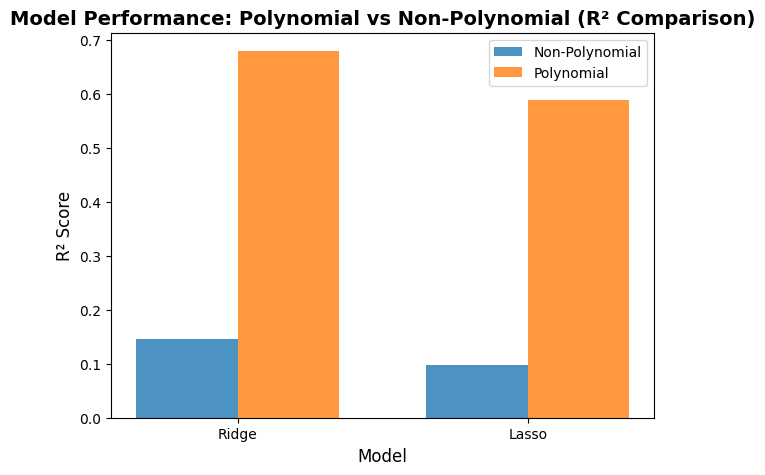

In [43]:
data = {
    'Model': ['Ridge', 'Lasso'],
    'Non-Polynomial': [0.146, 0.098],   # example R²
    'Polynomial': [0.68, 0.59],       # OLS has no polynomial version
}

r2s = pd.DataFrame(data)

x2 = np.arange(len(r2s['Model']))  # label locations
width = 0.35  

fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x2 - width/2, r2s['Non-Polynomial'], width, label='Non-Polynomial', alpha=0.8)
bars2 = ax.bar(x2 + width/2, r2s['Polynomial'], width, label='Polynomial', alpha=0.8)

ax.set_ylabel('R² Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Model Performance: Polynomial vs Non-Polynomial (R² Comparison)', fontsize=14, weight='bold')
ax.set_xticks(x2)
ax.set_xticklabels(r2s['Model'])
ax.legend()

plt.show()

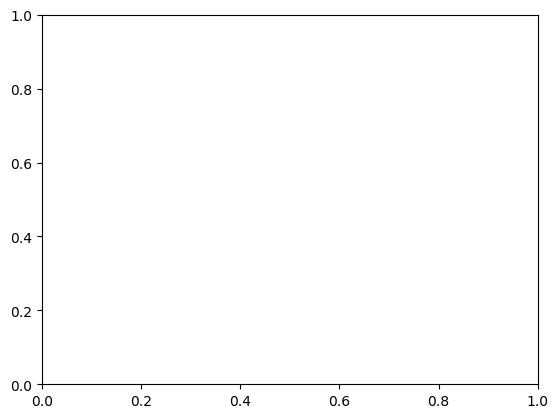

<class 'ValueError'>: x and y must be the same size

In [44]:
plt.scatter(
    df['Inflation'], 
    linear_baseline_df['Predicted Inflation'], 
    alpha=0.6,
    label='Predictions'
)

min_val = min(linear_baseline_df['True Inflation'].min(), df['Predicted Inflation'].min())
max_val = max(linear_baseline_df['True Inflation'].max(), df['Predicted Inflation'].max())
line_range = np.linspace(min_val - 0.5, max_val + 0.5, 100)

# Y=X
plt.plot(
    line_range, 
    line_range, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label='Perfect Prediction ($y=x$)'
)

plt.title('Actual vs. Predicted Inflation')
plt.xlabel('True Inflation Rate')
plt.ylabel('Predicted Inflation Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare data ---
y_true = final_y_test_ridge.values
y_pred_nonpoly = final_y_pred_ridge.values
y_pred_poly = final_y_pred_poly_ridge.values

# --- Compute regression line (least squares fit) for both models ---
m1, b1 = np.polyfit(y_true, y_pred_nonpoly, 1)
m2, b2 = np.polyfit(y_true, y_pred_poly, 1)

# --- Scatter plot ---
plt.figure(figsize=(7,6))
plt.scatter(y_true, y_pred_nonpoly, alpha=0.6, color='royalblue', label='Ridge (Non-Poly)')
plt.scatter(y_true, y_pred_poly, alpha=0.6, color='darkorange', label='Ridge (Poly)')

# --- Regression lines ---
x_line = np.linspace(min(y_true), max(y_true), 100)
plt.plot(x_line, m1*x_line + b1, color='royalblue', linestyle='--', linewidth=2)
plt.plot(x_line, m2*x_line + b2, color='darkorange', linestyle='--', linewidth=2)

# --- Perfect prediction line (y=x) for reference ---
plt.plot(x_line, x_line, color='black', linestyle=':', linewidth=1.5, label='Perfect Fit')

# --- Labels & Aesthetics ---
plt.title('Ridge Regression: Polynomial vs Non-Polynomial\nActual vs Predicted Inflation', fontsize=13, weight='bold')
plt.xlabel('Actual Inflation Movement', fontsize=12)
plt.ylabel('Predicted Inflation Movement', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# CHATGPT ACCESSED 06/11/2025